In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_process as tsp
from statsmodels.sandbox.tsa.fftarma import ArmaFft as FftArmaProcess
import statsmodels.tsa.stattools as tss
from statsmodels.graphics.tsaplots import plot_acf

from math import *
from scipy import *
from cmath import *
from numpy import *
import numpy as np
import fileinput
import re
import pandas as pd
from scipy.interpolate import spline
from sklearn.metrics import *
#import seaborn as sns
from datetime import timedelta
import datetime
import calendar
import os
import matplotlib.ticker as ticker
#from wavelets import WaveletAnalysis
#get_ipython().magic('matplotlib inline')
#get_ipython().magic(u'pylab inline')
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_format = 'svg'

In [2]:
from optimizador_de_NR import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
def stack_cota(df,consistencia):
    """Recebe Dataframe de cotas da ANA (header=15) e retorna dataframe com cotas em colunas (Dia, Cota, Mes, Ano).
    Também recebe o Nível de Consistencia desejado (1 - Inconsistido, 2- Consistido)"""
    dfc = df[df.NivelConsistencia == consistencia]
    if consistencia == 1:
        dfc = dfc[dfc.MediaDiaria == 1]
    dfc.index = range(len(dfc))
    dft = dfc.ix[:,16:47]
    dft.index = dfc.Data
    dft.columns = range(1,32)
    df = dft
    print(len(df))
    if len(df)!=0:
        vert = pd.DataFrame(index = pd.date_range(dft.index.min(),add_months(dft.index.max(),1)))
        dfcol = pd.DataFrame(df.stack())
        dfcol.columns =  ['Data']
        dfcol.to_csv('temp.csv',sep='\t',header=['Cota'])
        vert.to_csv('temp2.csv',sep='\t')
        dateparse2 = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
        df = pd.read_csv('temp.csv',sep='\t', parse_dates=['Data'], date_parser=dateparse2)
        df.columns = ['Data', 'Dia', 'Cota']
        df.index = df.Data+ map(lambda x: timedelta(days=float(x)-1.), df.Dia.tolist())
        vert['Data'] = vert.index
        df['Data'] = df.index
        finalmente = pd.merge(vert,df,on='Data')
        finalmente = vert.join(df,lsuffix='_l',rsuffix='_r')
        finalmente['Mes'] = finalmente.index.month
        finalmente['Dia'] = finalmente.index.dayofyear
        finalmente['Ano'] = finalmente.index.year
        return finalmente
    else:
        return pd.Series(np.nan)

Here we define were pictures and tables should be saved.

In [4]:
figuras = 'C:\\Users\\Usuario\\OneDrive\\Mestrado\\Artigos\\PIANC\\RN\\Dados\\Saida\\figuras\\'
tabelas = 'C:\\Users\\Usuario\\OneDrive\\Mestrado\\Artigos\\PIANC\\RN\\Dados\\Saida\\tabelas\\'

Here we define the river station that we want.

In [5]:
estacao = 66825000

This defines a function for Date reading, defines the origin of the data, read the data, copy then into 2 separate groups (Consisted and Inconsisted) data, apply the Stack_cota function for both groups and then merge them (optional).

In [6]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
root = 'C:\\Users\\Usuario\\OneDrive\\Mestrado\\Artigos\\PIANC\\RN\\Dados\\Cotas\\'+str(estacao)
df = pd.read_csv(root+'\\COTAS.TXT',header=15,sep=';', parse_dates=['Data'], date_parser=dateparse,decimal=',')
inconsistido = stack_cota(df,1)
consistido = stack_cota(df,2)
cotg = merge_consistido(consistido,inconsistido)

1395
1247


THIS ROTINE MAKES THE YEARS START IN JULY. EX: JULY OF 1990 WILL NOW BE THE FIRST MONTH OF 1991.

TO ACCOMPLISH THAT IT GIVES TO ALL JULYS THE VALUE OF THE FOLLOWING YEAR IN THE ANO2 COLUMNS.

In [7]:
cotg['new_year']=np.NAN
cotg['Ano2']=np.NAN
cotg['Ano2'] = cotg['Ano']
cotg['Ano2'][cotg.index.month>6] = np.array(cotg.Ano[cotg.index.month>6].tolist()) +1
aux = cotg.Ano-1
cotg['new_year'] = aux.astype('str')+cotg.Ano.astype('str')
cotg['new_year'][cotg.index.month>6] = cotg.Ano[cotg.index.month>6].astype('str')+ cotg.Ano2[cotg.index.month>6].astype('str')

In [8]:
resumo =  cotg[cotg.Cota.notnull()].pivot_table(values = 'Cota', index=['Dia','Mes'], columns='Ano2')
r_stat = resumo.describe(percentiles=linspace(0,1,21)).T

In [9]:
print(resumo.head(2))

Ano2      1900   1901   1902   1903   1904   1905   1906   1907   1908   1909  \
Dia Mes                                                                         
1   1    186.0  191.0  168.0  141.0  240.0  298.0  190.0  150.0  168.0  210.0   
2   1    185.0  193.0  172.0  140.0  240.0  300.0  190.0  151.0  168.0  210.0   

Ano2     ...     2007   2008   2009   2010   2011  2012   2013   2014   2015  \
Dia Mes  ...                                                                   
1   1    ...    243.0  196.0  108.0  164.0  100.0  82.0  124.0  117.5  222.5   
2   1    ...    245.0  196.0  107.0  164.0  100.0  82.0  126.0  116.0  222.0   

Ano2      2016  
Dia Mes         
1   1    145.5  
2   1    146.5  

[2 rows x 117 columns]


In [10]:
r_stat.tail(20).to_latex('asd.tex')

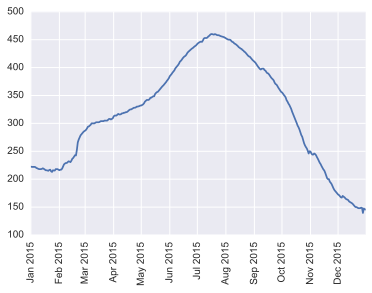

In [11]:
plt.plot(cotg[cotg.Ano==2015].index,cotg[cotg.Ano==2015].Cota)
#plt.plot(cotg[cotg.Ano==2016].index,cotg[cotg.Ano==2016].Cota)
plt.xticks(rotation=90)
plt.savefig('2015.pdf',bbox_inches='tight')

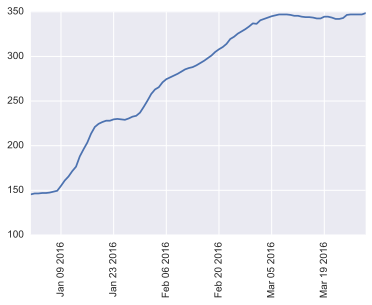

In [12]:
#plt.plot(cotg[cotg.Ano==2015].index,cotg[cotg.Ano==2015].Cota)
plt.plot(cotg[cotg.Ano==2016].index,cotg[cotg.Ano==2016].Cota)
plt.xticks(rotation=90)
plt.savefig('2016.pdf',bbox_inches='tight')

In [13]:
T1Va=[40,1991,0,10]
T1Ta=[40,1991,10,10]

###SECOND (BASIC - DIFERENT PERIODS)

T2Va=[40,1996,0,5]
T2Ta=[40,1996,5,10]


###THIRD (COMBINATION - 2 FORECAST EVENTS)

T3Va=[40,1961,0,10]
T3Ta=[40,1961,10,10]

T3Vb=[40,1966,0,5]
T3Tb=[40,1966,5,10]

###FOURTH (COMBINATION - 2 FORECAST EVENTS)
T4Va=[40,1951,0,10]
T4Ta=[40,1951,10,10]

T4Vb=[40,1956,0,5]
T4Tb=[40,1956,5,10]

###FIFTH (TESTE WITH COMPLEX VARIATION)

T5Va=[40,1941,0,10]
T5Ta=[40,1941,10,10]

T5Vb=[40,1946,0,5]
T5Tb=[40,1946,5,10]

In [14]:
parametros=[T1Va,
T1Ta,
T2Va,
T2Ta,
T3Va,
T3Ta,
T3Vb,
T3Tb,
T4Va,
T4Ta,
T4Vb,
T4Tb,
T5Va,
T5Ta,
T5Vb,
T5Tb]

In [15]:
forecast_parameters = pd.DataFrame(pd.DataFrame(parametros).ix[[0,4,8,12],:].as_matrix())

In [16]:
import foracast_models

In [17]:
rc('font',family='Senasds Serif',size=10)
sns.set_style("darkgrid")
sns.set(palette="colorblind")
sns.set_context("paper")

## Basic Model - Percentil 20

In [18]:
reload(foracast_models)

bm_20 = foracast_models.basic_forecast()

bm_20.set_parameters(forecast_parameters,20,r_stat,cotg)

bm_20.forecast(cotg)

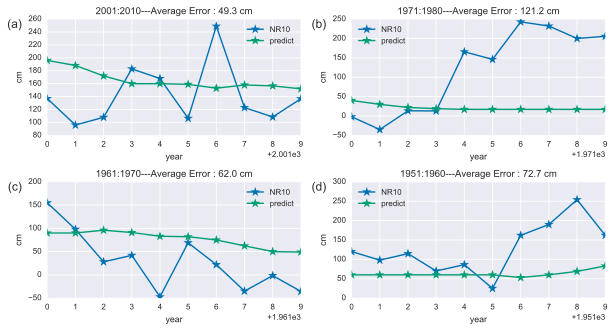

In [19]:
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.40)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(10,5))
ax_t2 = [ax,ax1,ax2,ax3]
for i in range(len(forecast_parameters)):
    a = ax_t2[i]
    fig = plt.figure(figsize=(4,2))
    bm_20.test_results['BM_nr'][i].plot(marker='*',markersize=10,ax=ax_t2[i])
    bm_20.test_results['BM_Prediction'][i].plot(marker='*',markersize=10,ax=ax_t2[i])
    #bm_20.test_results['BM_Error'][i].plot(kind='bar')
    #plt.yticks(range(0,100,10))
    a.legend(loc='best')
    a.set_ylabel('cm')
    a.set_title(str(bm_20.forecast_parameters.ix[i:i,1:2].values[0][0]+bm_20.forecast_parameters.ix[i:i,3:4].values[0][0])+
              ':'+str(bm_20.forecast_parameters.ix[i:i,1:2].values[0][0]+bm_20.forecast_parameters.ix[i:i,3:4].values[0][0]+
              bm_20.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(bm_20.test_results['BM_Error'][i].mean(),1))+' cm')
    #plt.show()
ax.text(-0.1, 1., '(a)', transform=ax.transAxes,
  fontsize=12, va='top', ha='right')
ax1.text(-0.1, 1., '(b)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='right')
ax2.text(-0.1, 1., '(c)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='right')
ax3.text(-0.1, 1., '(d)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='right')
f.savefig(figuras+'bm_20_teste_multiple.pdf',bbox_inches='tight')

In [20]:
bm_20.test_results.BM_Error[0].mean()

49.32000000000001

In [21]:
bm20 = bm_20.test_results.copy()

In [22]:
bm20.BM_Error[0].mean()

49.32000000000001

## Basic Model - Percentil 1

In [23]:
reload(foracast_models)

bm_01 = foracast_models.basic_forecast()

bm_01.set_parameters(forecast_parameters,1,r_stat,cotg)

bm_01.forecast(cotg)

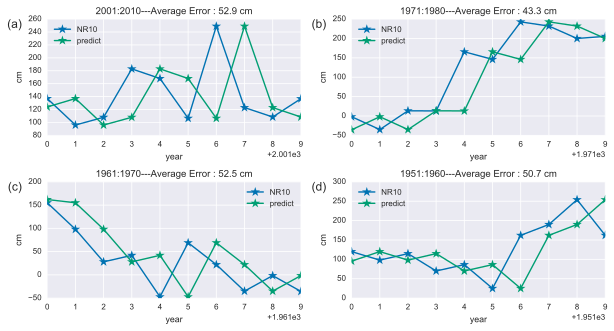

In [24]:
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.40)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(10,5))
ax_t = [ax,ax1,ax2,ax3]
for i in range(len(forecast_parameters)):
    a = ax_t[i]
    fig = plt.figure(figsize=(4,2))
    bm_01.test_results['BM_nr'][i].plot(marker='*',markersize=10,ax=ax_t[i])
    bm_01.test_results['BM_Prediction'][i].plot(marker='*',markersize=10,ax=ax_t[i])
    #bm_01.test_results['BM_Error'][i].plot(kind='bar')
    #plt.yticks(range(0,100,10))
    a.legend(loc='best')
    a.set_ylabel('cm')
    a.set_title(str(bm_01.forecast_parameters.ix[i:i,1:2].values[0][0]+bm_01.forecast_parameters.ix[i:i,3:4].values[0][0])+
              ':'+str(bm_01.forecast_parameters.ix[i:i,1:2].values[0][0]+bm_01.forecast_parameters.ix[i:i,3:4].values[0][0]+
              bm_01.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(bm_01.test_results['BM_Error'][i].mean(),1))+' cm')
ax.text(-0.1, 1., '(a)', transform=ax.transAxes,
  fontsize=12, va='top', ha='right')
ax1.text(-0.1, 1., '(b)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='right')
ax2.text(-0.1, 1., '(c)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='right')
ax3.text(-0.1, 1., '(d)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='right')   
f.savefig(figuras+'bm_1_teste_multiple.pdf',bbox_inches='tight')
    #plt.show()

## AR(1)

In [25]:
rc('font',family='Senasds Serif',size=10)
sns.set_style("darkgrid")
sns.set(palette="colorblind")
sns.set_context("paper")

In [26]:
reload(foracast_models)

<module 'foracast_models' from 'foracast_models.pyc'>

In [27]:
ar_test_1 = foracast_models.auto_regression()

In [28]:
ar_test_1.set_parameters(forecast_parameters,1,r_stat,cotg)

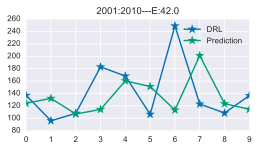

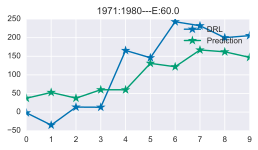

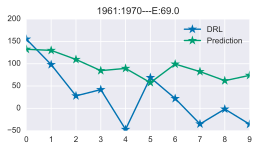

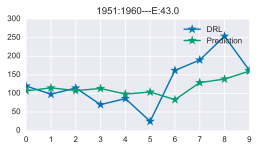

In [29]:
ar_test_1.forecast()

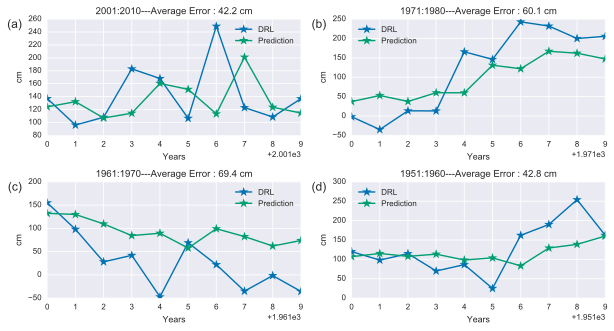

In [30]:
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.40)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(10,5))

ax_t = [ax,ax1,ax2,ax3]
for i in range(len(forecast_parameters)):
    a = ax_t[i]
    ar_test_1.test_results_summary[i].index = ar_test_1.test_results_summary[i].Years
    ar_test_1.test_results_summary[i]['DRL'].plot(marker='*',markersize=10,ax=ax_t[i])
    
    ar_test_1.test_results_summary[i]['Prediction'].plot(marker='*',markersize=10,ax=ax_t[i])
    #self.test_results['Error'].plot(kind='bar')
    #plt.yticks(range(0,100,10))
    a.legend(loc='best')
    a.set_ylabel('cm')
    a.set_title(str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0])+
              ':'+str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]+
              ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(ar_test_1.test_results_summary[i]['Error'].mean(),1))+' cm')
ax.text(-0.1, 1., '(a)', transform=ax.transAxes,
  fontsize=12, va='top', ha='right')
ax1.text(-0.1, 1., '(b)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='right')
ax2.text(-0.1, 1., '(c)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='right')
ax3.text(-0.1, 1., '(d)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='right')
f.savefig(figuras+'ar1_teste_multiple.pdf',bbox_inches='tight')

## MR

In [31]:
reload(foracast_models)

<module 'foracast_models' from 'foracast_models.pyc'>

In [32]:
mr1 =  foracast_models.multiple_regression()

In [33]:
mr1.set_parameters(forecast_parameters,1,r_stat,cotg,12)

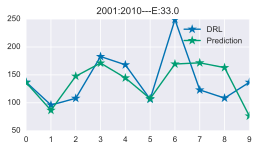

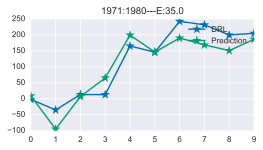

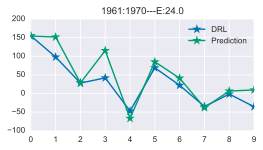

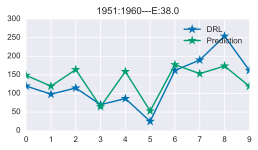

In [34]:
mr1.forecast()

In [35]:
mr1.forecast_results.Error.mean()

32.42261497444389

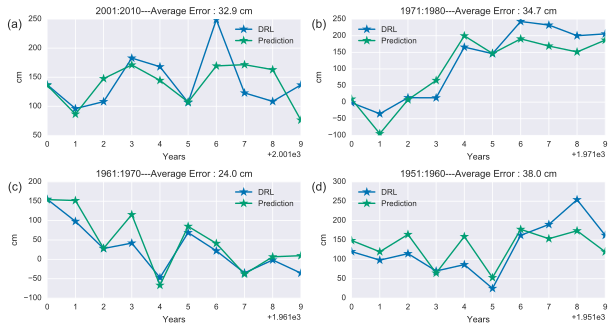

In [36]:
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.40)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(10,5))
ax_t = [ax,ax1,ax2,ax3]
for i in range(len(forecast_parameters)):
    a = ax_t[i]
    mr1.test_results_summary[i].index = mr1.test_results_summary[i].Years
    mr1.test_results_summary[i]['DRL'].plot(marker='*',markersize=10,ax=ax_t[i])
    
    mr1.test_results_summary[i]['Prediction'].plot(marker='*',markersize=10,ax=ax_t[i])
    #self.test_results['Error'].plot(kind='bar')
    #plt.yticks(range(0,100,10))
    a.legend(loc='best')
    a.set_ylabel('cm')
    a.set_title(str(mr1.forecast_parameters.ix[i:i,1:2].values[0][0]+mr1.forecast_parameters.ix[i:i,3:4].values[0][0])+
              ':'+str(mr1.forecast_parameters.ix[i:i,1:2].values[0][0]+mr1.forecast_parameters.ix[i:i,3:4].values[0][0]+
              mr1.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(mr1.test_results_summary[i]['Error'].mean(),1))+' cm')
ax.text(-0.1, 1., '(a)', transform=ax.transAxes,
  fontsize=12, va='top', ha='right')
ax1.text(-0.1, 1., '(b)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='right')
ax2.text(-0.1, 1., '(c)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='right')
ax3.text(-0.1, 1., '(d)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='right')
f.savefig(figuras+'mr1_teste_multiple.pdf',bbox_inches='tight')

## ANN

In [37]:
models = []
for i in range(1949,2010):
    models.append(pd.read_pickle('best_result'+str(i)+'.P')[0][0])

In [38]:
def forecast_error(s_model):
    s_model.test_prediction2 = s_model.network.activate(s_model.test_values_x_norm.values[0])
    print(s_model.test_values_y_norm.index)
    ymax = s_model.training_values_y.max()
    ymin = s_model.training_values_y.min()
    ypredict = pd.DataFrame((np.array(s_model.test_prediction2)*(ymax-ymin))+ymin)
    yreal = pd.DataFrame((np.array(s_model.test_values_y_norm)*(ymax-ymin))+ymin)
    return([abs(yreal[0].values[0] -ypredict[0].values[0]),ypredict[0].values[0], yreal[0].values[0]])

In [39]:
error_results= map(lambda x: forecast_error(models[x]),range(len(models)))

Int64Index([1951], dtype='int64', name=u'Ano2')
Int64Index([1952], dtype='int64', name=u'Ano2')
Int64Index([1953], dtype='int64', name=u'Ano2')
Int64Index([1954], dtype='int64', name=u'Ano2')
Int64Index([1955], dtype='int64', name=u'Ano2')
Int64Index([1956], dtype='int64', name=u'Ano2')
Int64Index([1957], dtype='int64', name=u'Ano2')
Int64Index([1958], dtype='int64', name=u'Ano2')
Int64Index([1959], dtype='int64', name=u'Ano2')
Int64Index([1960], dtype='int64', name=u'Ano2')
Int64Index([1961], dtype='int64', name=u'Ano2')
Int64Index([1962], dtype='int64', name=u'Ano2')
Int64Index([1963], dtype='int64', name=u'Ano2')
Int64Index([1964], dtype='int64', name=u'Ano2')
Int64Index([1965], dtype='int64', name=u'Ano2')
Int64Index([1966], dtype='int64', name=u'Ano2')
Int64Index([1967], dtype='int64', name=u'Ano2')
Int64Index([1968], dtype='int64', name=u'Ano2')
Int64Index([1969], dtype='int64', name=u'Ano2')
Int64Index([1970], dtype='int64', name=u'Ano2')
Int64Index([1971], dtype='int64', name=u

In [40]:
error_results  = pd.DataFrame(error_results)

In [41]:
error_results.columns = ['Error', 'Predict', 'Real']

In [42]:
error_results.head(5)

,Error,Predict,Real
0,27.407476,147.407476,120.0
1,32.673703,130.673703,98.0
2,33.517670,148.317670,114.8
3,28.107450,41.892550,70.0
4,47.516327,133.916327,86.4


In [43]:
error_results.index = range(1951,2012)

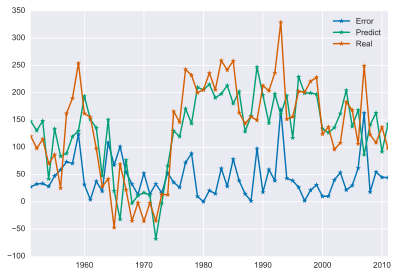

In [44]:
error_results.plot(marker='*')

In [45]:
error_results.Error.mean()

44.59860812768862

,Error
count,10.000000
mean,52.701568
std,30.408949
min,27.407476
25%,31.867501
50%,40.516998
75%,67.483455
max,123.858894


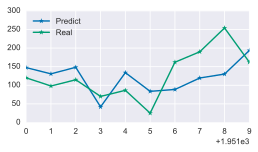

In [46]:
plt.figure(figsize(4,2))
error_results.ix[1951:1960,1:].plot(marker='*')
error_results.ix[1951:1960,:1].describe()

,Error
count,10.000000
mean,49.020327
std,35.325122
min,3.977517
25%,22.650800
50%,44.988707
75%,64.094619
max,108.504943


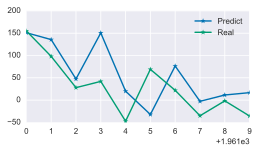

In [47]:
plt.figure(figsize(4,2))
error_results.ix[1961:1970,1:].plot(marker='*')
error_results.ix[1961:1970,:1].describe()

,Error
count,10.000000
mean,34.909295
std,28.435188
min,0.189861
25%,14.664426
50%,29.616578
75%,48.774510
max,88.567557


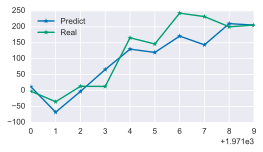

In [48]:
plt.figure(figsize(4,2))
error_results.ix[1971:1980,1:].plot(marker='*')
error_results.ix[1971:1980,:1].describe()

,Error
count,10.000000
mean,43.959839
std,46.912077
min,1.931625
25%,22.597961
50%,34.866325
75%,42.104411
max,168.940300


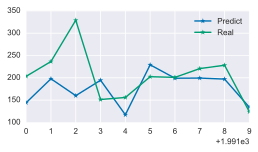

In [49]:
plt.figure(figsize(4,2))
error_results.ix[1991:2000,1:].plot(marker='*')
error_results.ix[1991:2000,:1].describe()

,Error
count,10.000000
mean,49.706973
std,43.174452
min,10.269644
25%,23.677782
50%,42.408782
75%,54.412581
max,162.516778


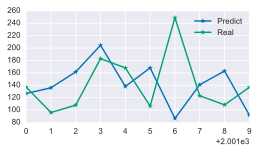

In [50]:
plt.figure(figsize(4,2))
error_results.ix[2001:2010,1:].plot(marker='*')
error_results.ix[2001:2010,:1].describe()

In [51]:
a = error_results.ix[1951:1960,:1]
b =error_results.ix[1961:1970,:1]
c = error_results.ix[1971:1980,:1]
d = error_results.ix[2001:2010,:1]

In [52]:
a.values

array([[  27.40747588],
       [  32.67370332],
       [  33.51766954],
       [  28.10745027],
       [  47.51632705],
       [  58.62055761],
       [  73.27708471],
       [  70.43775374],
       [ 123.85889354],
       [  31.59876737]])

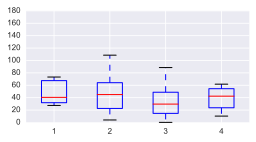

In [53]:
plt.boxplot([a.values,b.values,c.values,d.values])
plt.show()

In [54]:
models[0].monthly_values.tail(10).to_latex('monthly_values2.tex')

In [55]:
error_results.columns = [u'Error', u'Predict', u'DRL']

In [56]:
error_results.ix[2001:2010].Error.mean()

49.70697319584216

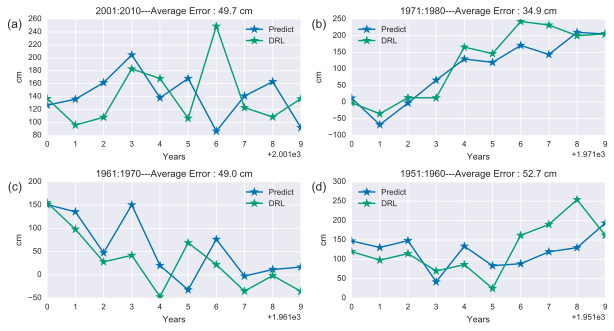

In [57]:
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.40)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(10,5))
ax_t = [ax,ax1,ax2,ax3]


error_results.ix[2001:2010,1:].plot(marker='*',markersize=10,ax=ax)
error_results.ix[1971:1980,1:].plot(marker='*',markersize=10,ax=ax1)
error_results.ix[1961:1970,1:].plot(marker='*',markersize=10,ax=ax2)
error_results.ix[1951:1960,1:].plot(marker='*',markersize=10,ax=ax3)


    #self.test_results['Error'].plot(kind='bar')
    #plt.yticks(range(0,100,10))
ax.text(-0.1, 1., '(a)', transform=ax.transAxes,
  fontsize=12, va='top', ha='right')
ax1.text(-0.1, 1., '(b)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='right')
ax2.text(-0.1, 1., '(c)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='right')
ax3.text(-0.1, 1., '(d)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='right')

ax.legend(loc='best')
ax.set_ylabel('cm')
ax.set_xlabel('Years')
i = 0
ax.set_title(str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0])+
          ':'+str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]+
          ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(error_results.ix[2001:2010].Error.mean(),1))+' cm')

i = 1
ax1.set_title(str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0])+
          ':'+str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]+
          ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(error_results.ix[1971:1980].Error.mean(),1))+' cm')
ax1.legend(loc='best')
ax1.set_ylabel('cm')
ax1.set_xlabel('Years')


i = 2
ax2.set_title(str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0])+
          ':'+str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]+
          ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(error_results.ix[1961:1970].Error.mean(),1))+' cm')
ax2.legend(loc='best')
ax2.set_ylabel('cm')
ax2.set_xlabel('Years')


i = 3
ax3.set_title(str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0])+
          ':'+str(ar_test_1.forecast_parameters.ix[i:i,1:2].values[0][0]+ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]+
          ar_test_1.forecast_parameters.ix[i:i,3:4].values[0][0]-1) + '---Average Error : '+str(round(error_results.ix[1951:1960].Error.mean(),1))+' cm')
ax3.legend(loc='best')
ax3.set_ylabel('cm')
ax3.set_xlabel('Years')


f.savefig(figuras+'ann_teste_multiple.pdf',bbox_inches='tight')

# ERROR SUMMARY

C:\Anaconda\lib\site-packages\seaborn\categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


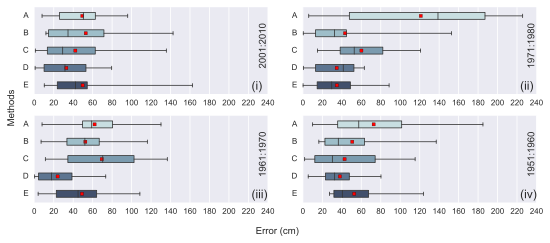

In [58]:
from seaborn import boxplot
sns.set_context("paper")
a = [[2001,2010],[1971,1980],[1961,1970],[1951,1960]]
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.25), "wspace": (0.15)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(9,3.5))
ax_t = [ax,ax1,ax2,ax3]
for i in range(4):
    axis = ax_t[i]
    grafico=pd.DataFrame()
    
    grafico['A'] = bm20.BM_Error[i]
    grafico['B'] = bm_01.test_results.BM_Error[i]
    grafico['C'] = ar_test_1.test_results_summary[i].Error
    grafico['D'] = mr1.test_results_summary[i].Error
    grafico['E'] = error_results.ix[a[i][0]:a[i][1]].Error
    boxplot(grafico,fliersize=10,whis=200,width=0.4,linewidth=0.8,showmeans=False,ax=ax_t[i],vert=0,color='Black', palette=sns.cubehelix_palette(5,12,dark=0.3,rot=-.20))#palette=sns.cubehelix_palette(6,12,rot=-.15))
    
    axis.set_title(str(a[i][0])+':'+str(a[i][1]))
    #ax2.legend(loc='best')
    #axis.set_xlabel('Error (cm)')
    #axis.set_ylabel('Methods')
    axis.set_xlim(0,200)
    axis.set_xticks(range(0,250,20))
    
    axis.scatter(grafico.mean(),[0,1,2,3,4],c='r',marker='s',s=10)
    
    title = str(a[i][0])+':'+ str(a[i][1])
    axis.set_title(title,x=0.98,y=0.68,rotation='vertical')
    
    
f.text(0.09,0.5, 'Methods', ha='center', va='center',rotation='vertical')
f.text(0.5,0.01, 'Error (cm)', ha='center', va='center',rotation='horizontal')    


ax.text(0.93, .15, '(i)', transform=ax.transAxes,
  fontsize=12, va='top', ha='left')
ax1.text(0.93, .15, '(ii)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='left')
ax2.text(0.93, .15, '(iii)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='left')
ax3.text(0.93, .15, '(iv)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='left')


f.savefig(figuras+'\\boxplota_.pdf',bbox_inches='tight')

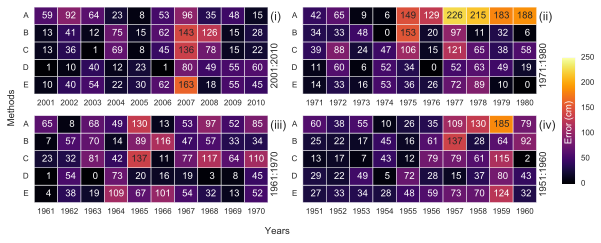

In [59]:
sns.set_context("paper")
#rc('font',family='Senasds Serif',size=10)
a = [[2001,2010],[1971,1980],[1961,1970],[1951,1960]]
grid_kws = {"height_ratios": (.5,.5), "hspace": (0.25), "wspace": (0.15)}
f, ((ax,ax1),(ax2,ax3)) = plt.subplots(2,2, gridspec_kw=grid_kws,figsize=(9,3.5))
ax_t = [ax,ax1,ax2,ax3]
for i in range(4):
    axis = ax_t[i]
    grafico=pd.DataFrame()
    
    grafico['A'] = bm20.BM_Error[i]
    grafico['B'] = bm_01.test_results.BM_Error[i]
    grafico['C'] = ar_test_1.test_results_summary[i].Error
    grafico['D'] = mr1.test_results_summary[i].Error
    grafico['E'] = error_results.ix[a[i][0]:a[i][1]].Error
    grafico.index =grafico.index.astype('int')
    #boxplot(grafico,fliersize=10,whis=200,width=0.4,linewidth=0.8,showmeans=False,ax=ax_t[i],vert=0,color='Black', palette=sns.cubehelix_palette(5,12,dark=0.3,rot=-.20))#palette=sns.cubehelix_palette(6,12,rot=-.15))
    
    #axis.set_title(str(a[i][0])+':'+str(a[i][1]))
    #ax2.legend(loc='best')
    #axis.set_xlabel('Error (cm)')
    #axis.set_ylabel('Methods')
    
    cbar_ax = f.add_axes([.94, .2, .02,0.5])
    title = str(a[i][0])+':'+ str(a[i][1])
    axis.set_title(title,x=1.03,y=0.45,rotation='vertical')
    sns.heatmap(grafico.T,ax=axis,annot=True,cmap='inferno',cbar=i/3. == 0,fmt='3.0f',vmin=0, vmax=250,linewidths=.5,square=0,cbar_ax=cbar_ax)#cbar_kws={"orientation": "horizontal"}
    axis.set_xlabel('')
    axis.set_yticklabels(axis.yaxis.get_majorticklabels(), rotation=0)
    
    
ax.text(1.01, .95, '(i)', transform=ax.transAxes,
  fontsize=12, va='top', ha='left')
ax1.text(1.01, .95, '(ii)', transform=ax1.transAxes,
      fontsize=12, va='top', ha='left')
ax2.text(1.01, .95, '(iii)', transform=ax2.transAxes,
  fontsize=12, va='top', ha='left')
ax3.text(1.01, .95, '(iv)', transform=ax3.transAxes,
      fontsize=12, va='top', ha='left')

f.text(0.09,0.5, 'Methods', ha='center', va='center',rotation='vertical')
f.text(0.5,0.01, 'Years', ha='center', va='center',rotation='horizontal')  

plt.text(0.15,0.6,'Error (cm)',rotation=90,color='white')
f.savefig(figuras+'\\error_.pdf',bbox_inches='tight')

In [75]:
bm_01.test_results.BM_Error[1].describe()

count     10.000000
mean      43.270000
std       47.199107
min        0.400000
25%       13.000000
50%       32.500000
75%       44.700000
max      152.600000
Name: erro, dtype: float64

In [81]:
# Erro médio BM20
print(pd.DataFrame(map(lambda x: bm20.BM_Error[x].mean(),range(4))).describe())

# Erro médio BM01
print(pd.DataFrame(map(lambda x: bm_01.test_results.BM_Error[x].mean(),range(4))).describe())

# Erro médio AR01
print(pd.DataFrame(map(lambda x: ar_test_1.test_results_summary[x].Error.mean(),range(4))).describe())

# Erro médio MR
print(pd.DataFrame(map(lambda x:  mr1.test_results_summary[x].Error.mean(),range(4))).describe())

# Erro médio ARR
print(pd.DataFrame(map(lambda x:  error_results.ix[a[x][0]:a[x][1]].Error.mean(),range(4))).describe())

                0
count    4.000000
mean    76.292500
std     31.397035
min     49.320000
25%     58.815000
50%     67.350000
75%     84.827500
max    121.150000
               0
count   4.000000
mean   49.836250
std     4.479846
min    43.270000
25%    48.842500
50%    51.590000
75%    52.583750
max    52.895000
               0
count   4.000000
mean   53.645027
std    13.395840
min    42.225344
25%    42.667534
50%    51.470810
75%    62.448303
max    69.413144
               0
count   4.000000
mean   32.422615
std     6.013531
min    23.977099
25%    30.700283
50%    33.836416
75%    35.558748
max    38.040529
               0
count   4.000000
mean   46.584541
std     7.945901
min    34.909295
25%    45.492569
50%    49.363650
75%    50.455622
max    52.701568


In [130]:
A = []
B = []
C = []
D = []
E = []

In [131]:
# Erro médio BM20
map(lambda x: A.append(bm20.BM_Error[x].tolist()),range(4))

# Erro médio BM01
map(lambda x: B.append(bm_01.test_results.BM_Error[x].tolist()),range(4))

# Erro médio AR01
map(lambda x: C.append(ar_test_1.test_results_summary[x].Error.tolist()),range(4))

# Erro médio MR
map(lambda x:  D.append(mr1.test_results_summary[x].Error.tolist()),range(4))

# Erro médio ARR
map(lambda x:  E.append(error_results.ix[a[x][0]:a[x][1]].Error.tolist()),range(4))

[None, None, None, None]

In [132]:
print(pd.DataFrame(np.array(A).reshape(40)).describe())
print(pd.DataFrame(np.array(B).reshape(40)).describe())
print(pd.DataFrame(np.array(C).reshape(40)).describe())
print(pd.DataFrame(np.array(D).reshape(40)).describe())
print(pd.DataFrame(np.array(E).reshape(40)).describe())

                0
count   40.000000
mean    76.292500
std     60.028443
min      6.000000
25%     35.000000
50%     59.500000
75%    100.300000
max    225.800000
                0
count   40.000000
mean    49.836250
std     40.946457
min      0.400000
25%     16.700000
50%     33.800000
75%     65.500000
max    152.600000
                0
count   40.000000
mean    53.645027
std     39.881994
min      1.102385
25%     16.645754
50%     44.110157
75%     78.797484
max    136.690748
               0
count  40.000000
mean   32.422615
std    24.702287
min     0.385941
25%    10.776347
50%    28.225354
75%    52.343253
max    80.219491
                0
count   40.000000
mean    46.584541
std     34.156718
min      0.189861
25%     25.199415
50%     36.647157
75%     59.393839
max    162.516778


In [133]:
resumo = pd.DataFrame()

resumo['A'] = pd.DataFrame(np.array(A).reshape(40)).describe()[0]
resumo['B'] = pd.DataFrame(np.array(B).reshape(40)).describe()[0]
resumo['C'] = pd.DataFrame(np.array(C).reshape(40)).describe()[0]
resumo['D'] = pd.DataFrame(np.array(D).reshape(40)).describe()[0]
resumo['E'] = pd.DataFrame(np.array(E).reshape(40)).describe()[0]

#resumo.index = pd.DataFrame(np.array(A).reshape(40)).describe().index

In [135]:
resumo.round(1)

,A,B,C,D,E
count,40.0,40.0,40.0,40.0,40.0
mean,76.3,49.8,53.6,32.4,46.6
std,60.0,40.9,39.9,24.7,34.2
min,6.0,0.4,1.1,0.4,0.2
25%,35.0,16.7,16.6,10.8,25.2
50%,59.5,33.8,44.1,28.2,36.6
75%,100.3,65.5,78.8,52.3,59.4
max,225.8,152.6,136.7,80.2,162.5


In [129]:
resumo.round(1).to_latex(tabelas+'resumo_forecast_methods.tex')